In [1]:
import logging
import sys
import pandas as pd
import numpy as np


# to include the SR code without installing in the environment
sys.path.append('../')

from symbolic_regression.SymbolicRegressor import SymbolicRegressor
from symbolic_regression.multiobjective.fitness.Regression import create_regression_weights

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


In [3]:
import plotly.express as px

# The operations

Here we define the list of allowed operations. In this project we implemented most of the arithmetic operations we expect to need in a normal use. Please have a look at the file in `symbolic_regression/operators.py` to see how we define them and to define your own operators.

In [4]:
from symbolic_regression.operators import *

operations = [
    OPERATOR_ADD,
    OPERATOR_SUB,
    OPERATOR_MUL,
    OPERATOR_DIV,
    # OPERATOR_ABS,
    # OPERATOR_MOD,
    # OPERATOR_NEG,
    # OPERATOR_INV,
    OPERATOR_LOG,
    OPERATOR_EXP,
    OPERATOR_POW,
    OPERATOR_SQRT,
    OPERATOR_SIN,
    OPERATOR_COS,
    #OPERATOR_MAX,
    #OPERATOR_MIN
]


# The example dataset: DEXA


In [5]:
def min_max_normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (
            df[feature_name] - min_value) / (max_value - min_value)
    return result


def std_normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        mean_val = df[feature_name].mean()
        std_val = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_val) / std_val
    return result


In [6]:
dsl = ['./dexa_new_train_0.csv', './dexa_new_val_0.csv', './dexa_new_test_0.csv']
dfl = []
for d in dsl:
    dfl.append(pd.read_csv(d, index_col=0))
data = pd.concat(dfl)
data

patient_id  is_male  age  height  weight_kg  \
1858  DEC5A0835D0041949D67BAA7A15815F4        1   49   177.0       62.0   
243   DEC5A010641ACC8413405735178F5E12        0   51   167.0       62.0   
974   DEC5A0476FD161FF85BF322DF4C289C3        1   40   183.0       75.0   
387   DEC5A0689492F5FE7A1F6A46D816A538        0   40   163.0       49.0   
2933  DEC5A0CF983D7D343DF2608E40558C03        1   53   170.0       63.0   
...                                ...      ...  ...     ...        ...   
793   DEC5A03B5B272FAED01E5DE955AEA777        1   38   190.0       90.0   
1062  DEC5A04C9B8B9D952E0CE1680FDE5EE2        0   48   177.0       84.0   
2876  DEC5A0CA350B81539E4C11673F91B907        0   50   165.0       79.0   
952   DEC5A045F24B012B564D6E382CE22190        1   62   174.0       64.0   
225   DEC5A00EDE888E77D85EBED356B35DFF        1   38   162.0       65.0   

      body_mass_index  hips_circumference  waist_circumference  \
1858             20.0                83.0                 78.0   
243              22.0                93.0                 82.0   
974              23.0                90.0                 88.0   
387               NaN                90.0                 66.0   
2933             22.0                86.0                 83.0   
...               ...                 ...                  ...   
793              25.0               104.0                 97.0   
1062             27.0               102.0                106.0   
2876             29.0               103.0                102.0   
952              21.0                90.0                 87.0   
225              25.0                90.0                 81.0   

      dexa_leg_bone_mass_grams  dexa_leg_fat_mass_grams  ...  \
1858                     872.0                   1254.0  ...   
243                      714.0                   5666.0  ...   
974                     1236.0                   2396.0  ...   
387                        NaN                      NaN  ...   
2933                     734.0                   1028.0  ...   
...                        ...                      ...  ...   
793                     1282.0                  10719.0  ...   
1062                    1046.0                   7920.0  ...   
2876                     701.0                   4627.0  ...   
952                      827.0                   2689.0  ...   
225                      916.0                   4709.0  ...   

      visceral_adipose_tissue  total_adipose_tissue  \
1858                    131.0                 154.0   
243                     168.0                 340.0   
974                      86.0                 178.0   
387                       NaN                   NaN   
2933                     78.0                 105.0   
...                       ...                   ...   
793                      75.0                 346.0   
1062                    134.0                 508.0   
2876                    232.0                 532.0   
952                     121.0                 222.0   
225                      75.0                 235.0   

      comorbidity_lipodystrophy  comorbidity_menopause  \
1858                          1                      0   
243                           1                      0   
974                           0                      0   
387                           0                      0   
2933                          1                      0   
...                         ...                    ...   
793                           0                      0   
1062                          1                      0   
2876                          1                      0   
952                           1                      0   
225                           0                      0   

      comorbidity_metabolic_syndrome  leg_fat_perc  body_fat_perc      VSFR  \
1858                               1      0.064856       0.095388  5.695652   
243                                0      0.30750

In [7]:
data=data[['is_male', 'age', 'height', 'weight_kg', 'hips_circumference', 'waist_circumference', 'comorbidity_lipodystrophy',
       'comorbidity_menopause', 'comorbidity_metabolic_syndrome',
       'leg_fat_perc', 'body_fat_perc', 'VSFR', 'BMI']]

mean_data=data.mean()
std_data=data.std()


data[['age', 'height', 'weight_kg', 'hips_circumference', 'waist_circumference','leg_fat_perc', 'body_fat_perc', 'VSFR', 'BMI']]=std_normalize(data[['age', 'height', 'weight_kg',
       'hips_circumference', 'waist_circumference','leg_fat_perc', 'body_fat_perc', 'VSFR', 'BMI']])
data.describe()

is_male           age        height     weight_kg  \
count  3570.000000  3.570000e+03  3.570000e+03  3.570000e+03   
mean      0.688235 -2.050025e-16  2.866055e-16 -2.647120e-16   
std       0.463279  1.000000e+00  1.000000e+00  1.000000e+00   
min       0.000000 -3.837063e+00 -3.105469e+00 -2.193981e+00   
25%       0.000000 -6.008158e-01 -6.608366e-01 -6.822357e-01   
50%       1.000000 -1.510853e-03  3.762980e-02 -4.571119e-02   
75%       1.000000  5.977941e-01  7.360962e-01  5.908133e-01   
max       1.000000  4.553207e+00  4.228428e+00  3.932567e+00   

       hips_circumference  waist_circumference  comorbidity_lipodystrophy  \
count        3.570000e+03         3.570000e+03                3570.000000   
mean         5.065354e-16        -6.856638e-16                   0.664706   
std          1.000000e+00         1.000000e+00                   0.472159   
min         -5.299245e+00        -3.161143e+00                   0.000000   
25%         -6.416846e-01        -7.300813e-01                   0.000000   
50%         -7.713182e-02        -1.466264e-01                   1.000000   
75%          6.285591e-01         6.313135e-01                   1.000000   
max          4.298152e+00         4.521013e+00                   1.000000   

       comorbidity_menopause  comorbidity_metabolic_syndrome  leg_fat_perc  \
count            3570.000000                     3570.000000  3.570000e+03   
mean                0.079272                        0.261905  4.727000e-17   
std                 0.270200                        0.439733  1.000000e+00   
min                 0.000000                        0.000000 -1.463921e+00   
25%                 0.000000                        0.000000 -8.248330e-01   
50%                 0.000000                        0.000000 -1.796212e-01   
75%                 0.000000                        1.000000  6.636770e-01   
max                 1.000000                        1.000000  3.237322e+00   

       body_fat_perc          VSFR           BMI  
count   3.570000e+03  2.599000e+03  3.570000e+03  
mean    1.328536e-16 -5.946250e-17 -2.955619e-16  
std     1.000000e+00  1.000000e+00  1.000000e+00  
min    -2.122392e+00 -1.021419e+00 -2.920646e+00  
25%    -7.533301e-01 -6.283218e-01 -6.849469e-01  
50%    -6.847642e-02 -3.022981e-01 -1.009157e-01  
75%     6.904699e-01  2.636949e-01  5.758430e-01  
max     3.289885e+00  7.771836e+00  4.950861e+00

In [8]:
features=['is_male', 'age', 'height', 'weight_kg', 'hips_circumference',
       'waist_circumference', 'comorbidity_lipodystrophy',
       'comorbidity_menopause', 'comorbidity_metabolic_syndrome']

target='body_fat_perc'


#F_y=get_cumulant_hist(data=data,target=target)
weights='w'
data[weights]=create_regression_weights(data=data,target=target)



Here we define the base range for which to generate the constants in the individuals. Furthermore, we also define how to optimize those constants in order to make them converge to the best value they can have in their expression.

We are using the scipy optimizer.

In [9]:
const_range = (0, 1)

constants_optimization = 'scipy'
constants_optimization_conf = {
    'task': 'regression:wmse',  # or 'binary:logistic'
    'learning_rate': 1e-4,
    'batch_size': int(np.ceil(len(data)/10)),
    'epochs': 50,
    'verbose': 0,
    'gradient_clip': False,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-7,
    'l1_param': 0,
    'l2_param': 0,
}


In [10]:
def sample_partition(data, target, n_sample=100, n_bin=10, alpha=100, replace=True, seed=42):
    np.random.seed(seed)
    # draw a sample from a Dirichlet distribution with the concentration parameter alpha
    cat_prob = np.random.dirichlet([alpha]*n_bin)
    # draw a sample from a multinomial distribution with the previously sampled parameters
    samples_per_bin = np.random.multinomial(n_sample, cat_prob, size=1)
    
    # divide the dataset into equal-sized bins
    bins = pd.qcut(data[target], q = n_bin, labels=False, duplicates='drop')
    
    # generate a dataset with the defined distribution
    out = pd.concat([data[bins.eq(label)].sample(num, replace=replace, random_state=seed) 
                     for label, num in enumerate(samples_per_bin[0])
                     if data[bins.eq(label)].size>0 
                    ])
    return out



In [11]:
data_c1 = sample_partition(data, target, n_sample=200, alpha=10, seed=0)
data_c2 = sample_partition(data, target, n_sample=500, alpha=10, seed=1)
data_c3 = sample_partition(data, target, n_sample=1000, alpha=10, seed=2)

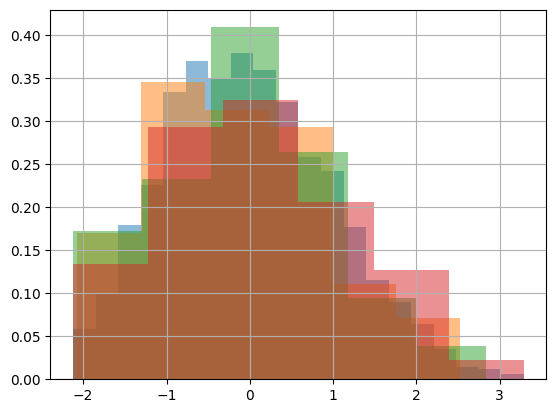

In [12]:
data[target].hist(bins=20, alpha=0.5, density=True);
data_c1[target].hist(bins=6, alpha=0.5, density=True);
data_c2[target].hist(bins=6, alpha=0.5, density=True);
data_c3[target].hist(bins=6, alpha=0.5, density=True);

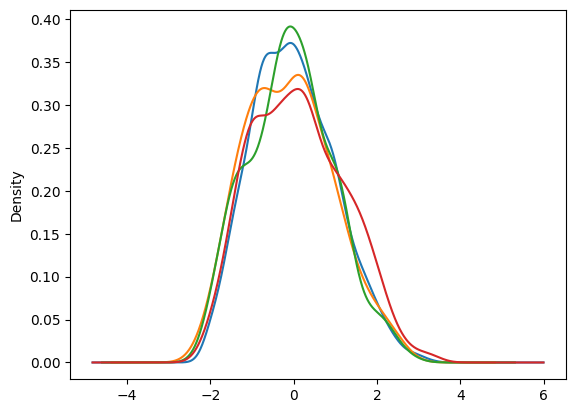

In [13]:
data[target].plot.kde();
data_c1[target].plot.kde();
data_c2[target].plot.kde();
data_c3[target].plot.kde();

In [14]:
from symbolic_regression.multiobjective.fitness.DistributionPreserving import Wasserstein
from symbolic_regression.multiobjective.fitness.Correlation import KendallTauCorrelation
from symbolic_regression.multiobjective.fitness.Regression import WeightedMeanSquaredError
from symbolic_regression.multiobjective.fitness.Regression import WMSEBIC, WMSEBICScaled

fitness_functions = [
    WMSEBICScaled(label='bic1',data= data_c1, target=target,
                             minimize=True, 
                             hypervolume_reference=data_c1[target].abs().max(), 
                             constants_optimization=constants_optimization, 
                             constants_optimization_conf=constants_optimization_conf,
                             n0=200),
    WMSEBICScaled(label='bic2',data= data_c2, target=target,
                              minimize=True, 
                              hypervolume_reference=data_c2[target].abs().max(), 
                              constants_optimization=constants_optimization, 
                              constants_optimization_conf=constants_optimization_conf,
                              n0=200),
    WMSEBICScaled(label='bic3',data= data_c3, target=target,
                              minimize=True, 
                              hypervolume_reference=data_c3[target].abs().max(), 
                              constants_optimization=constants_optimization, 
                              constants_optimization_conf=constants_optimization_conf,
                              n0=200),
]
"""
    WeightedMeanSquaredError(label='wmse', target=target,
                             weights=weights, minimize=True, hypervolume_reference=data[target].abs().max(), 
                             constants_optimization=constants_optimization, 
                             constants_optimization_conf=constants_optimization_conf),
]

    KendallTauCorrelation(label='1-kendalltau', target=target,
                          one_minus=True, minimize=True, hypervolume_reference=1.1),
    Wasserstein(label='wasserstein', target=target, weights=weights, F_y=F_y,
                bins=10, minimize=True, hypervolume_reference=1.1)
]
"""


''' Use this to modulate the relative frequency of genetic operations
    E.g., crossover is chosen 2 times more frequently than mutation
        {
            'crossover': 2,
            'mutation': 1,
            # etc...
        }
'''
genetic_operators_frequency = {
    'crossover': 1,
    'mutation': 1,
    'insert_node': 2,
    'delete_node': 1,
    'mutate_leaf': 1,
    'mutate_operator': 1,
    'recalibrate': 1
}


In [15]:
from symbolic_regression.callbacks.CallbackSave import MOSRCallbackSaveCheckpoint
from symbolic_regression.callbacks.CallbackStatistics import MOSRHistory, MOSRStatisticsComputation

file_name = f'./dexa_federated'

callbacks = [
    MOSRCallbackSaveCheckpoint(
        checkpoint_file=file_name, checkpoint_frequency=25, checkpoint_overwrite=True),
    MOSRStatisticsComputation(statistics_computation_frequency=1, compute_hypervolume=True),
    MOSRHistory(history_fpf_frequency=10),
]

In [16]:
POPULATION_SIZE = 100
TOURNAMENT_SIZE = 3

logging.info(f'Running with POPULATION_SIZE {POPULATION_SIZE}')
logging.info(f'Running with TOURNAMENT_SIZE {TOURNAMENT_SIZE}')


sr = SymbolicRegressor(
    client_name='client',
    const_range=const_range,
    parsimony=.9,
    parsimony_decay=.95,  # Expected depth = parsimony / (1-parsimony_decay)
    population_size=POPULATION_SIZE,
    tournament_size=TOURNAMENT_SIZE,
    genetic_operators_frequency=genetic_operators_frequency,
    callbacks=callbacks,
)


In [17]:
GENERATIONS = 100

sr.fit(
    data=data,
    features=features,
    operations=operations,
    fitness_functions=fitness_functions,
    generations_to_train=GENERATIONS,
    n_jobs=-1,
    stop_at_convergence=False,
    verbose=3  # The output could be very verbose. Consider using 0, 1, or 2 to reduce the verbosity
)

print('End')


Initializing population


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


###############################################################################################
Generation 0:00:00 - On average: 00:00:00 ± 00:00:00 - Total: 00:00:00 - To completion: Unknown
###############################################################################################
client: starting generation 1/100
Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 131/131 (0:00:03, 43.67 /s). Completed!
Computing statistics for generation 1
Saving FPF history for generation 1

Average complexity of 7.3 and 1PF of length 3 and Hypervolume 1149.61/164131921

	Best individual(s) in the first Pareto Front
0)	cos((weight_kg + (-3.2580032543257094 * sin((0.500581254052129 * exp((weight_kg + (-0.767962634822171 * hips_circumference))))))))

	Train fitness
	{'bic1': 559.76359, 'bic2': 507.66805, 'bic3': 538.83397}

1)	((0.9587396584988622 * comorbidity_menopause) + ((0.5380494920487946 * waist_circumference) + ((-0.01816819076554563 * age) + (0

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 29/29 (0:00:02, 14.5 /s). Completed!
Computing statistics for generation 9

Average complexity of 15.6 and 1PF of length 3 and Hypervolume 881136.75/164131921

	Best individual(s) in the first Pareto Front
0)	((0.5804981917221357 * hips_circumference) + (log((exp(weight_kg) ** 0.11035167587662098)) + sin(sin(cos(Sqrt((3.7364647654380603 * is_male)))))))

	Train fitness
	{'bic1': 448.67549, 'bic2': 451.15847, 'bic3': 454.35864}

1)	(((0.6961784095814852 * hips_circumference) + ((0.40152577638244197 * comorbidity_menopause) + (log((exp(weight_kg) ** 0.11946365930073222)) + sin(sin(cos(Sqrt((18.231320889589064 * is_male)))))))) * sin(cos(Sqrt((39.47952967041296 * is_male)))))

	Train fitness
	{'bic1': 444.97667, 'bic2': 458.72006, 'bic3': 463.30095}

2)	((0.6512664382539056 * hips_circumference) + ((0.15628077013718195 * comorbidity_menopause) + sin(sin(cos(Sqrt((19.260898490367058 * is_male))))

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 35/35 (0:00:02, 17.5 /s). Completed!
Computing statistics for generation 16

Average complexity of 22.2 and 1PF of length 3 and Hypervolume 1523801.25/164131921

	Best individual(s) in the first Pareto Front
0)	((comorbidity_menopause + ((0.7487092955993773 * hips_circumference) + (log((exp(comorbidity_lipodystrophy) ** -0.43036753833980596)) + sin(sin(cos(Sqrt((21.34784090714234 * is_male)))))))) * sin(cos(Sqrt((39.479781564104215 * is_male)))))

	Train fitness
	{'bic1': 422.13679, 'bic2': 446.15779, 'bic3': 450.72924}

1)	((0.17424755753437 * age) + ((0.5930733270140943 * hips_circumference) + (1.5944760871486385 * sin((log((exp(comorbidity_lipodystrophy) ** -0.36242196597403675)) + sin(sin(cos(Sqrt((2.364458360980087 * is_male))))))))))

	Train fitness
	{'bic1': 430.31429, 'bic2': 434.20087, 'bic3': 434.986}

2)	((0.6374777842693587 * hips_circumference) + ((-0.344050389875173 * comorbidit

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 39/39 (0:00:02, 19.5 /s). Completed!
Computing statistics for generation 22

Average complexity of 24.5 and 1PF of length 4 and Hypervolume 2017925.11/164131921

	Best individual(s) in the first Pareto Front
0)	(-0.35974623776432063 + ((1.3801062753069078 * log(exp(cos(comorbidity_lipodystrophy)))) + ((0.29231288635718033 * comorbidity_menopause) + ((0.4100937149512838 * hips_circumference) + ((0.3219161420889379 * waist_circumference) + ((-0.8465877844680669 * is_male) + (-0.31296624845023935 * (height * sin(cos((0.04638065657940385 ** Sqrt((19.31250222491225 * is_male)))))))))))))

	Train fitness
	{'bic1': 406.24634, 'bic2': 435.22998, 'bic3': 429.84842}

1)	((0.34483507316967993 * waist_circumference) + ((1.2407703017028917 * log(exp(cos(comorbidity_lipodystrophy)))) + ((-0.02394735119816426 * comorbidity_lipodystrophy) + ((-1.2017864284772035 * is_male) + sin((0.41344402995208457 * hips_c

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 37/37 (0:00:02, 18.5 /s). Completed!
Computing statistics for generation 27

Average complexity of 26.9 and 1PF of length 4 and Hypervolume 2229471.69/164131921

	Best individual(s) in the first Pareto Front
0)	((0.3535299623760399 * hips_circumference) + ((0.3557684852728674 * waist_circumference) + ((1.2287058834617872 * log(exp(cos(comorbidity_lipodystrophy)))) + (-1.2131247119201494 * is_male))))

	Train fitness
	{'bic1': 417.48424, 'bic2': 424.21081, 'bic3': 420.83687}

1)	(0.4945283136456215 + ((0.3579907377173975 * waist_circumference) + ((comorbidity_menopause + ((0.41876591020609727 * hips_circumference) + (log((exp(comorbidity_lipodystrophy) ** -0.7242893870612239)) + sin(sin(cos(Sqrt((4.972520475083341 * is_male)))))))) * sin(cos(Sqrt((0.8903216131581567 * comorbidity_menopause)))))))

	Train fitness
	{'bic1': 411.93719, 'bic2': 434.70045, 'bic3': 431.97237}

2)	(-0.399973212675459

Offsprings generated: 100/100 (0:00:13, 7.69 /s). Completed!     
Duplicates/invalid refilled: 33/33 (0:00:02, 16.5 /s). Completed!
Computing statistics for generation 31

Average complexity of 29.0 and 1PF of length 4 and Hypervolume 2500366.89/164131921

	Best individual(s) in the first Pareto Front
0)	(comorbidity_menopause + ((0.34329370291172073 * hips_circumference) + ((-0.6358185431925161 * comorbidity_lipodystrophy) + ((0.353566513728031 * waist_circumference) + cos(Sqrt((2.2966723727536418 * is_male)))))))

	Train fitness
	{'bic1': 404.48982, 'bic2': 433.49405, 'bic3': 432.29848}

1)	((-0.615886188271875 * comorbidity_lipodystrophy) + ((-0.8610256041209853 * is_male) + ((-0.24723479587493927 * height) + (exp((0.2525108245381546 * waist_circumference)) + sin((0.5513874441970459 * hips_circumference))))))

	Train fitness
	{'bic1': 405.10864, 'bic2': 419.73485, 'bic3': 407.60797}

2)	((0.3051025530194735 * waist_circumference) + ((0.40455283431308553 * hips_circumference) + ((-1.

Offsprings generated: 100/100 (0:00:13, 7.69 /s). Completed!     
Duplicates/invalid refilled: 35/35 (0:00:02, 17.5 /s). Completed!
Computing statistics for generation 36

Average complexity of 29.4 and 1PF of length 3 and Hypervolume 2621562.04/164131921

	Best individual(s) in the first Pareto Front
0)	((0.3179940426131505 * waist_circumference) + ((0.41371611131783753 * hips_circumference) + ((-0.45098979818158563 * exp(is_male)) + ((0.2964009011944391 * comorbidity_menopause) + ((1.405693826635579 * log(exp(cos(comorbidity_lipodystrophy)))) + (-0.4411025010443511 * (height * sin(cos((0.9030026810741582 ** Sqrt((0.8906265409010256 * is_male))))))))))))

	Train fitness
	{'bic1': 399.33438, 'bic2': 429.8471, 'bic3': 424.41805}

1)	((0.1811724298789265 * sin(age)) + ((-0.6178727988081582 * comorbidity_lipodystrophy) + ((-0.8565916595319906 * is_male) + ((-0.23523193930918604 * height) + (exp((0.23343150515482444 * waist_circumference)) + sin((0.5481560350972647 * hips_circumference))))

Offsprings generated: 100/100 (0:00:14, 7.14 /s). Completed!     
Duplicates/invalid refilled: 40/40 (0:00:02, 20.0 /s). Completed!
Computing statistics for generation 41

Average complexity of 29.1 and 1PF of length 5 and Hypervolume 2757085.79/164131921

	Best individual(s) in the first Pareto Front
0)	((0.18117240669318738 * sin(age)) + ((-0.8565916511409881 * is_male) + ((-0.6178728146009583 * comorbidity_lipodystrophy) + ((-0.23523194645387924 * height) + (exp((0.2334315047929533 * waist_circumference)) + sin((0.5481560360906594 * hips_circumference)))))))

	Train fitness
	{'bic1': 401.05599, 'bic2': 418.03307, 'bic3': 406.811}

1)	((0.46664441765067327 * hips_circumference) + ((0.2696848556665665 * waist_circumference) + ((0.3606814132193244 * comorbidity_menopause) + ((-0.14055112734859498 * is_male) + ((-0.2892538349243641 * height) + sin((log((exp(comorbidity_lipodystrophy) ** -0.5531815468546664)) + sin(sin(cos(Sqrt((1.6456379441137228 * is_male))))))))))))

	Train fitness
	{

Offsprings generated: 100/100 (0:00:14, 7.14 /s). Completed!     
Duplicates/invalid refilled: 41/41 (0:00:03, 13.67 /s). Completed!
Computing statistics for generation 44

Average complexity of 28.2 and 1PF of length 8 and Hypervolume 2836089.89/164131921

	Best individual(s) in the first Pareto Front
0)	((0.36067931898523803 * comorbidity_menopause) + ((0.269682979112145 * waist_circumference) + ((0.46664559937018807 * hips_circumference) + ((-0.14050781947293292 * is_male) + ((-0.2892489296627233 * height) + sin((log((exp(comorbidity_lipodystrophy) ** -0.5531737995591123)) + sin(sin(cos(Sqrt((1.645791167548986 * is_male))))))))))))

	Train fitness
	{'bic1': 392.88695, 'bic2': 424.69025, 'bic3': 422.87293}

1)	((-0.617872831024984 * comorbidity_lipodystrophy) + ((0.18117243126087168 * sin(age)) + ((-0.8565916263798647 * is_male) + ((-0.23523195382740625 * height) + (exp((0.233431502723885 * waist_circumference)) + sin((0.5481560455940165 * hips_circumference)))))))

	Train fitness
	{

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 43/43 (0:00:02, 21.5 /s). Completed!
Computing statistics for generation 47

Average complexity of 28.5 and 1PF of length 8 and Hypervolume 2918420.46/164131921

	Best individual(s) in the first Pareto Front
0)	((0.3413392647252519 * comorbidity_menopause) + ((0.480035853986379 * hips_circumference) + ((0.256978913215622 * waist_circumference) + ((-0.3340984491664459 * exp(is_male)) + ((-0.5655088005511497 * (height * sin(cos((1.2052222518353455 ** Sqrt((comorbidity_menopause * is_male))))))) + log(exp(cos(comorbidity_lipodystrophy))))))))

	Train fitness
	{'bic1': 389.32713, 'bic2': 419.38388, 'bic3': 418.71758}

1)	((-0.23523193014678426 * height) + ((0.18117244808270694 * sin(age)) + ((-0.6178727924732741 * comorbidity_lipodystrophy) + ((-0.8565916659780073 * is_male) + (exp((0.23343150272195146 * waist_circumference)) + sin((0.5481560331719982 * hips_circumference)))))))

	Train fitness
	

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 53/53 (0:00:02, 26.5 /s). Completed!
Computing statistics for generation 50
Saving FPF history for generation 50

Average complexity of 28.2 and 1PF of length 9 and Hypervolume 3009222.67/164131921

	Best individual(s) in the first Pareto Front
0)	((0.499537167753851 * hips_circumference) + ((0.152374439119099 * sin(waist_circumference)) + ((0.15923505906315874 * waist_circumference) + ((-0.320674811888983 * exp(is_male)) + ((-0.32993607822155485 * height) + log(exp(cos(comorbidity_lipodystrophy))))))))

	Train fitness
	{'bic1': 402.06742, 'bic2': 411.28995, 'bic3': 416.91467}

1)	((0.18117242439637074 * sin(age)) + ((-0.8565916317750605 * is_male) + ((-0.6178728224298731 * comorbidity_lipodystrophy) + ((-0.2352319480340148 * height) + (exp((0.23343150474924096 * waist_circumference)) + sin((0.5481560418236714 * hips_circumference)))))))

	Train fitness
	{'bic1': 401.05599, 'bic2': 418.03307,

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 36/36 (0:00:02, 18.0 /s). Completed!
Computing statistics for generation 53

Average complexity of 28.6 and 1PF of length 9 and Hypervolume 3009222.67/164131921

	Best individual(s) in the first Pareto Front
0)	((0.49953716464972564 * hips_circumference) + ((0.15237440352590095 * sin(waist_circumference)) + ((0.15923507851435853 * waist_circumference) + ((-0.3299360740981283 * height) + ((-0.32067481535085374 * exp(is_male)) + log(exp(cos(comorbidity_lipodystrophy))))))))

	Train fitness
	{'bic1': 402.06742, 'bic2': 411.28995, 'bic3': 416.91467}

1)	((0.18117243808984237 * sin(age)) + ((-0.6178728206733253 * comorbidity_lipodystrophy) + ((-0.8565916309150094 * is_male) + ((-0.2352319483446937 * height) + (exp((0.2334315026171609 * waist_circumference)) + sin((0.5481560454197557 * hips_circumference)))))))

	Train fitness
	{'bic1': 401.05599, 'bic2': 418.03307, 'bic3': 406.811}

2)	((0.5130187

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 38/38 (0:00:02, 19.0 /s). Completed!
Computing statistics for generation 56

Average complexity of 28.3 and 1PF of length 12 and Hypervolume 3125810.02/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.8565916445116583 * is_male) + ((0.18117245766915288 * sin(age)) + ((-0.23523193045230906 * height) + ((-0.6178727942060275 * comorbidity_lipodystrophy) + (exp((0.23343149716173406 * waist_circumference)) + sin((0.5481560451812472 * hips_circumference)))))))

	Train fitness
	{'bic1': 401.05599, 'bic2': 418.03307, 'bic3': 406.811}

1)	((0.3177217288375023 * sin(waist_circumference)) + ((0.5480992079353848 * hips_circumference) + ((-0.3150787177016503 * exp(is_male)) + ((-0.33087240858168004 * height) + log(exp(cos(comorbidity_lipodystrophy)))))))

	Train fitness
	{'bic1': 408.47007, 'bic2': 406.07305, 'bic3': 413.87676}

2)	((0.4372110231206493 * hips_circumference) + ((0.181127122

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 51/51 (0:00:03, 17.0 /s). Completed!
Computing statistics for generation 58

Average complexity of 28.1 and 1PF of length 13 and Hypervolume 3125857.06/164131921

	Best individual(s) in the first Pareto Front
0)	((0.18117242677683743 * sin(age)) + ((-0.23523194032861908 * height) + ((-0.8565916404329615 * is_male) + ((-0.6178728149779288 * comorbidity_lipodystrophy) + (exp((0.23343150376935354 * waist_circumference)) + sin((0.5481560403983572 * hips_circumference)))))))

	Train fitness
	{'bic1': 401.05599, 'bic2': 418.03307, 'bic3': 406.811}

1)	((0.5480992062351208 * hips_circumference) + ((-0.31507871712749497 * exp(is_male)) + ((-0.3308724116815678 * height) + ((0.3177217277959679 * sin(waist_circumference)) + log(exp(cos(comorbidity_lipodystrophy)))))))

	Train fitness
	{'bic1': 408.47007, 'bic2': 406.07305, 'bic3': 413.87676}

2)	((0.4372110231206493 * hips_circumference) + ((0.181127122

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 42/42 (0:00:02, 21.0 /s). Completed!
Computing statistics for generation 60
Saving FPF history for generation 60

Average complexity of 28.5 and 1PF of length 14 and Hypervolume 3151122.97/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.19920514803984976 * height) + ((-1.1279089630418282 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124784532458 * hips_circumference)) + (sin((0.1778783728210862 * sin(age))) + sin((0.28593655936111617 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.3169038624854066 * comorbidity_menopause) + ((0.5354160095178955 * hips_circumference) + ((0.3260866080494119 * sin(waist_circumference)) + ((-0.3237122649715334 * exp(is_male)) + ((-0.2968568486916629 * height) + log(exp(cos(comorbidity_lipodystrophy))))))))

	Train fitness
	{'bic1': 397.15476, 'bic2': 407.9

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 53/53 (0:00:02, 26.5 /s). Completed!
Computing statistics for generation 62

Average complexity of 28.6 and 1PF of length 16 and Hypervolume 3217158.7/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.19920514803984976 * height) + ((-1.1279089630418282 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124784532458 * hips_circumference)) + (sin((0.1778783728210862 * sin(age))) + sin((0.28593655936111617 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.4516863128227028 * hips_circumference) + ((0.27526164630834665 * waist_circumference) + ((-0.34844809238047336 * exp(is_male)) + ((-0.4583645420934289 * (height * sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7

Offsprings generated: 100/100 (0:00:10, 10.0 /s). Completed!     
Duplicates/invalid refilled: 46/46 (0:00:02, 23.0 /s). Completed!
Computing statistics for generation 64

Average complexity of 28.6 and 1PF of length 12 and Hypervolume 3232381.46/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.19920514803984976 * height) + ((-1.1279089630418282 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124784532458 * hips_circumference)) + (sin((0.1778783728210862 * sin(age))) + sin((0.28593655936111617 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.4516863128227028 * hips_circumference) + ((0.27526164630834665 * waist_circumference) + ((-0.34844809238047336 * exp(is_male)) + ((-0.4583645420934289 * (height * sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.

Offsprings generated: 100/100 (0:00:10, 10.0 /s). Completed!     
Duplicates/invalid refilled: 31/31 (0:00:01, 31.0 /s). Completed!
Computing statistics for generation 66

Average complexity of 28.6 and 1PF of length 10 and Hypervolume 3233719.25/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.19920514803984976 * height) + ((-1.1279089630418282 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124784532458 * hips_circumference)) + (sin((0.1778783728210862 * sin(age))) + sin((0.28593655936111617 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.4516863128227028 * hips_circumference) + ((0.27526164630834665 * waist_circumference) + ((-0.34844809238047336 * exp(is_male)) + ((-0.4583645420934289 * (height * sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.


Average complexity of 28.8 and 1PF of length 11 and Hypervolume 3233726.33/164131921

	Best individual(s) in the first Pareto Front
0)	((0.45168631374548124 * hips_circumference) + ((-0.34844809171653623 * exp(is_male)) + ((0.27526164550271076 * waist_circumference) + ((-0.45836454217556466 * (height * sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.72319, 'bic2': 416.41821, 'bic3': 417.4814}

1)	((-0.19920514272299097 * height) + ((-1.127908954990118 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.17787839019194884 * sin(age))) + (sin((0.5279124867230804 * hips_circumference)) + sin((0.28593655808486373 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

2)	((0.5164758108395449 * hips_circumference) + sin(((0.25871877789930764 * waist_circumference) + ((-0.3330762935632468 * e

Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 37/37 (0:00:03, 12.33 /s). Completed!
Computing statistics for generation 72

Average complexity of 28.7 and 1PF of length 12 and Hypervolume 3234233.65/164131921

	Best individual(s) in the first Pareto Front
0)	((-1.1279089571228067 * sin(is_male)) + ((-0.19920514567332684 * height) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124896261563 * hips_circumference)) + (sin((0.28593655280626223 * waist_circumference)) + sin((0.17787839213155487 * sin(age))))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.27526164550549637 * waist_circumference) + ((0.45168631509269286 * hips_circumference) + ((-0.34844809195879445 * exp(is_male)) + ((-0.45836453454996196 * (height * sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 48/48 (0:00:02, 24.0 /s). Completed!
Computing statistics for generation 74

Average complexity of 28.9 and 1PF of length 13 and Hypervolume 3234243.66/164131921

	Best individual(s) in the first Pareto Front
0)	((0.45168631942172566 * hips_circumference) + ((-0.3484480913326188 * exp(is_male)) + ((0.27526163824489946 * waist_circumference) + ((-0.45836455688601935 * (height * sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.72319, 'bic2': 416.41821, 'bic3': 417.4814}

1)	((-1.1279089665982165 * sin(is_male)) + ((-0.19920514192324465 * height) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.2859365655548322 * waist_circumference)) + (sin((0.5279124741892334 * hips_circumference)) + sin((0.17787837768678047 * sin(age))))))))

	Train fitness
	{'bic1': 401.

############################################################################################
Generation 0:00:17 - On average: 0:00:18 ± 0:00:01 - Total: 0:23:30 - To completion: 0:07:39
############################################################################################
client: starting generation 76/100
Offsprings generated: 100/100 (0:00:12, 8.33 /s). Completed!     
Duplicates/invalid refilled: 42/42 (0:00:02, 21.0 /s). Completed!
Computing statistics for generation 76

Average complexity of 28.6 and 1PF of length 15 and Hypervolume 3234246.08/164131921

	Best individual(s) in the first Pareto Front
0)	((-1.1279089665982165 * sin(is_male)) + ((-0.19920514192324465 * height) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.2859365655548322 * waist_circumference)) + (sin((0.5279124741892334 * hips_circumference)) + sin((0.17787837768678047 * sin(age))))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((-0.34844809054078507 * exp(is_male)

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 32/32 (0:00:02, 16.0 /s). Completed!
Computing statistics for generation 78

Average complexity of 29.0 and 1PF of length 18 and Hypervolume 3234356.33/164131921

	Best individual(s) in the first Pareto Front
0)	((0.4516371352904842 * hips_circumference) + ((0.27536434666163195 * waist_circumference) + ((-0.3484411976115367 * exp(is_male)) + ((-0.47959910859082516 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-0.19920514521340582 * height) + ((-1.127908960074543 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.17787838174269613 * sin(age))) + (sin((0.2859365640465345 * waist_circumference)) + sin((0.5279124816267897 * hips_circumference)))))))

	Train fitness
	{'bic1': 4

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 35/35 (0:00:02, 17.5 /s). Completed!
Computing statistics for generation 80
Saving FPF history for generation 80

Average complexity of 29.0 and 1PF of length 19 and Hypervolume 3234656.47/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-1.1279089637651039 * sin(is_male)) + ((-0.19920514277544477 * height) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124726251367 * hips_circumference)) + (sin((0.17787837986151223 * sin(age))) + sin((0.2859365625936434 * waist_circumfere

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 36/36 (0:00:02, 18.0 /s). Completed!
Computing statistics for generation 82

Average complexity of 29.3 and 1PF of length 19 and Hypervolume 3234656.47/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-1.1279089637651039 * sin(is_male)) + ((-0.19920514277544477 * height) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124726251367 * hips_circumference)) + (sin((0.17787837986151223 * sin(age))) + sin((0.2859365625936434 * waist_circumference)))))))

	Train fitness
	{'bic1': 

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 41/41 (0:00:03, 13.67 /s). Completed!
Computing statistics for generation 84

Average complexity of 29.6 and 1PF of length 19 and Hypervolume 3234656.47/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-0.1992051431325995 * height) + ((-1.127908968006145 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.2859365656126499 * waist_circumference)) + (sin((0.5279124772711097 * hips_circumference)) + sin((0.17787838331763223 * sin(age))))))))

	Train fitness
	{'bic1': 4

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 38/38 (0:00:02, 19.0 /s). Completed!
Computing statistics for generation 86

Average complexity of 29.6 and 1PF of length 20 and Hypervolume 3235039.41/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-0.19920514521340582 * height) + ((-1.127908960074543 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.17787838174269613 * sin(age))) + (sin((0.2859365640465345 * waist_circumference)) + sin((0.5279124816267897 * hips_circumference)))))))

	Train fitness
	{'bic1': 4

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 40/40 (0:00:02, 20.0 /s). Completed!
Computing statistics for generation 88

Average complexity of 29.5 and 1PF of length 21 and Hypervolume 3235495.0/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-0.19920514521340582 * height) + ((-1.127908960074543 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.17787838174269613 * sin(age))) + (sin((0.2859365640465345 * waist_circumference)) + sin((0.5279124816267897 * hips_circumference)))))))

	Train fitness
	{'bic1': 40

Computing statistics for generation 89

Average complexity of 29.6 and 1PF of length 21 and Hypervolume 3235495.0/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-0.19920514521340582 * height) + ((-1.127908960074543 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.17787838174269613 * sin(age))) + (sin((0.2859365640465345 * waist_circumference)) + sin((0.5279124816267897 * hips_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

2)	((-0.061355806188423824 * exp(exp(is_male))) + ((-0.26170492368342035 * height) +

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 39/39 (0:00:03, 13.0 /s). Completed!
Computing statistics for generation 91

Average complexity of 29.5 and 1PF of length 21 and Hypervolume 3235495.0/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-0.19920514521340582 * height) + ((-1.127908960074543 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.17787838174269613 * sin(age))) + (sin((0.2859365640465345 * waist_circumference)) + sin((0.5279124816267897 * hips_circumference)))))))

	Train fitness
	{'bic1': 40

Computing statistics for generation 92

Average complexity of 29.5 and 1PF of length 21 and Hypervolume 3235495.0/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-1.1279089679293872 * sin(is_male)) + ((-0.1992051452501159 * height) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.2859365720204353 * waist_circumference)) + (sin((0.5279124720061293 * hips_circumference)) + sin((0.17787837483475338 * sin(age))))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

2)	((-0.061355806188423824 * exp(exp(is_male))) + ((-0.26170492368342035 * height) +

Offsprings generated: 100/100 (0:00:10, 10.0 /s). Completed!     
Duplicates/invalid refilled: 40/40 (0:00:02, 20.0 /s). Completed!
Computing statistics for generation 94

Average complexity of 29.4 and 1PF of length 13 and Hypervolume 3241958.47/164131921

	Best individual(s) in the first Pareto Front
0)	((0.2753643551007047 * waist_circumference) + ((-0.34844119835051357 * exp(is_male)) + ((0.45163713120189813 * hips_circumference) + ((-0.4795991089583704 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.7231, 'bic2': 416.42013, 'bic3': 417.48505}

1)	((-0.19920514521340582 * height) + ((-1.127908960074543 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.17787838174269613 * sin(age))) + (sin((0.2859365640465345 * waist_circumference)) + sin((0.5279124816267897 * hips_circumference)))))))

	Train fitness
	{'bic1': 4

Offsprings generated: 100/100 (0:00:11, 9.09 /s). Completed!     
Duplicates/invalid refilled: 35/35 (0:00:02, 17.5 /s). Completed!
Computing statistics for generation 96

Average complexity of 29.4 and 1PF of length 14 and Hypervolume 3241959.59/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.19920514563302982 * height) + ((-1.1279089543746033 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124783068717 * hips_circumference)) + (sin((0.1778783883709564 * sin(age))) + sin((0.2859365611880246 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.45163713999457933 * hips_circumference) + ((-0.3484411992560186 * exp(is_male)) + ((0.275364347479446 * waist_circumference) + ((-0.47959908610410684 * (height * sin(sin(cos((hips_circumference ** Sqrt((comorbidity_menopause * is_male)))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 3

Offsprings generated: 100/100 (0:00:10, 10.0 /s). Completed!     
Duplicates/invalid refilled: 41/41 (0:00:02, 20.5 /s). Completed!
Computing statistics for generation 98

Average complexity of 29.7 and 1PF of length 16 and Hypervolume 3242178.51/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.19920514563302982 * height) + ((-1.1279089543746033 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124783068717 * hips_circumference)) + (sin((0.1778783883709564 * sin(age))) + sin((0.2859365611880246 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.27600977226787815 * waist_circumference) + ((0.4486085302293802 * hips_circumference) + ((-0.35033581756580257 * exp(is_male)) + ((-0.43711330256208275 * (height * sin(cos((age ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train fitness
	{'bic1': 379.72321, 'bic2': 

Offsprings generated: 100/100 (0:00:10, 10.0 /s). Completed!     
Duplicates/invalid refilled: 39/39 (0:00:02, 19.5 /s). Completed!
Computing statistics for generation 100
Saving FPF history for generation 100

Average complexity of 29.7 and 1PF of length 17 and Hypervolume 3242742.65/164131921

	Best individual(s) in the first Pareto Front
0)	((-0.19920514563302982 * height) + ((-1.1279089543746033 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124783068717 * hips_circumference)) + (sin((0.1778783883709564 * sin(age))) + sin((0.2859365611880246 * waist_circumference)))))))

	Train fitness
	{'bic1': 401.40123, 'bic2': 413.60915, 'bic3': 405.86312}

1)	((0.4486085309290104 * hips_circumference) + ((-0.35033581629194166 * exp(is_male)) + ((0.2760097681240405 * waist_circumference) + ((-0.43711331286382277 * (height * sin(cos((age ** Sqrt((comorbidity_menopause * is_male))))))) + (log(exp(cos(comorbidity_lipodystrophy))) + sin(comorbidity_menopause))))))

	Train

In [18]:
sr.fpf_stats

n_individuals  fpf_hypervolume fpf_hypervolume_reference
1              1.0         0.000001                      None
2              1.0      3422.105920             499793.835785
3              1.0      3422.105920             499793.835785
4              2.0      5533.851771             499793.835785
5              2.0      5533.851771             499793.835785
..             ...              ...                       ...
96             6.0    164434.463400             499793.835785
97             6.0    164434.462876             499793.835785
98             6.0    164434.463453             499793.835785
99             6.0    164434.463453             499793.835785
100            6.0    164434.463523             499793.835785

[100 rows x 3 columns]

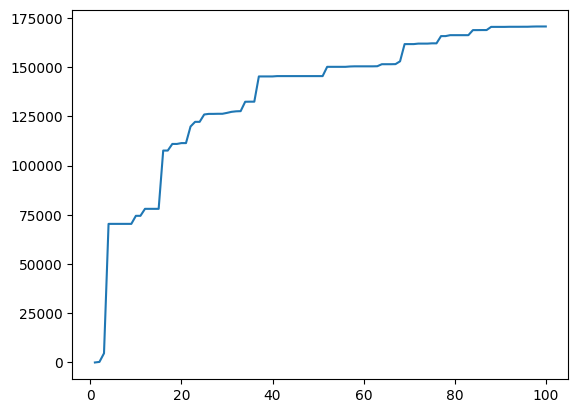

In [53]:
plt.plot(sr.fpf_stats["fpf_hypervolume"]);

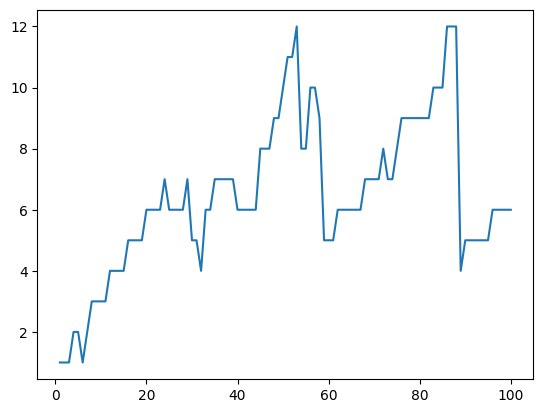

In [20]:
plt.plot(sr.fpf_stats["n_individuals"]);

### How to access the models and use them

You can access the models from ```sr.population: List``` or from ```sr.first_pareto_front: List```. The first one contains all the models generated during the evolution process, while the second one contains only the models that are in the Pareto front.

E.g., 
```python
model = sr.population[0]  # OR model = sr.first_pareto_front[0]
```

To see the model expression, use
```python
>>> str(model.program)  # It is only the string representation
```

Some relevant attributes of the model are
```python
>>> model.features_used
>>> model.fitness
>>> model.fitness_validation
```

To evaluate the model, use
```python
>>> model.evaluate(data)  # data should be a Dict, pd.Series or pd.DataFrame
```

In [17]:
PATH = './dexa_federated.client.sr'
sr = SymbolicRegressor(client_name='client').load_model(PATH)

In [18]:
sr.fpf_fitness_history

{1: [{'bic1': 559.76359, 'bic2': 507.66805, 'bic3': 538.83397},
  {'bic1': 528.84954, 'bic2': 525.40556, 'bic3': 558.04592},
  {'bic1': 549.74142, 'bic2': 518.52601, 'bic3': 541.45602}],
 2: [{'bic1': 559.76359, 'bic2': 507.66805, 'bic3': 538.83397},
  {'bic1': 514.5213, 'bic2': 510.46926, 'bic3': 543.49781},
  {'bic1': 549.74142, 'bic2': 518.52601, 'bic3': 541.45602},
  {'bic1': 549.74142, 'bic2': 518.52601, 'bic3': 541.45602},
  {'bic1': 549.74142, 'bic2': 518.52601, 'bic3': 541.45602}],
 3: [{'bic1': 513.37095, 'bic2': 498.94083, 'bic3': 538.83397},
  {'bic1': 513.87439, 'bic2': 504.1223, 'bic3': 537.69565}],
 4: [{'bic1': 511.86184, 'bic2': 498.83953, 'bic3': 532.77656}],
 5: [{'bic1': 490.48276, 'bic2': 468.78685, 'bic3': 495.36745}],
 6: [{'bic1': 454.11175, 'bic2': 455.3642, 'bic3': 458.16703}],
 7: [{'bic1': 446.91159, 'bic2': 451.42947, 'bic3': 455.18928}],
 8: [{'bic1': 448.67549, 'bic2': 451.15847, 'bic3': 454.35864},
  {'bic1': 446.91159, 'bic2': 451.42947, 'bic3': 455.1892

In [19]:
model = sr.first_pareto_front[0]

str(model.program)

'((-0.19920514563302982 * height) + ((-1.1279089543746033 * sin(is_male)) + (log(exp(cos(comorbidity_lipodystrophy))) + (sin((0.5279124783068717 * hips_circumference)) + (sin((0.1778783883709564 * sin(age))) + sin((0.2859365611880246 * waist_circumference)))))))'

Sample from the posterior distribution, given a dataset and a fractional value. NUTS is the default method.

In [20]:
model.sample(data_c1, target, beta=1)


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha0, alpha1, alpha2, alpha3, alpha4, sigma]
INFO:pymc.sampling.mcmc:NUTS: [alpha0, alpha1, alpha2, alpha3, alpha4, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [21]:
az.summary(model.trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha0 -0.171  0.050  -0.262   -0.079      0.001    0.001    2252.0    1484.0   
alpha1 -1.221  0.073  -1.354   -1.083      0.002    0.001    1931.0    1719.0   
alpha2  0.431  0.075   0.275    0.564      0.002    0.001    2013.0    1350.0   
alpha3  0.247  0.076   0.117    0.400      0.002    0.001    2101.0    1399.0   
alpha4  0.316  0.067   0.194    0.445      0.002    0.001    2028.0    1522.0   
sigma   0.628  0.033   0.569    0.694      0.001    0.000    2565.0    1632.0   

        r_hat  
alpha0    1.0  
alpha1    1.0  
alpha2    1.0  
alpha3    1.0  
alpha4    1.0  
sigma     1.0

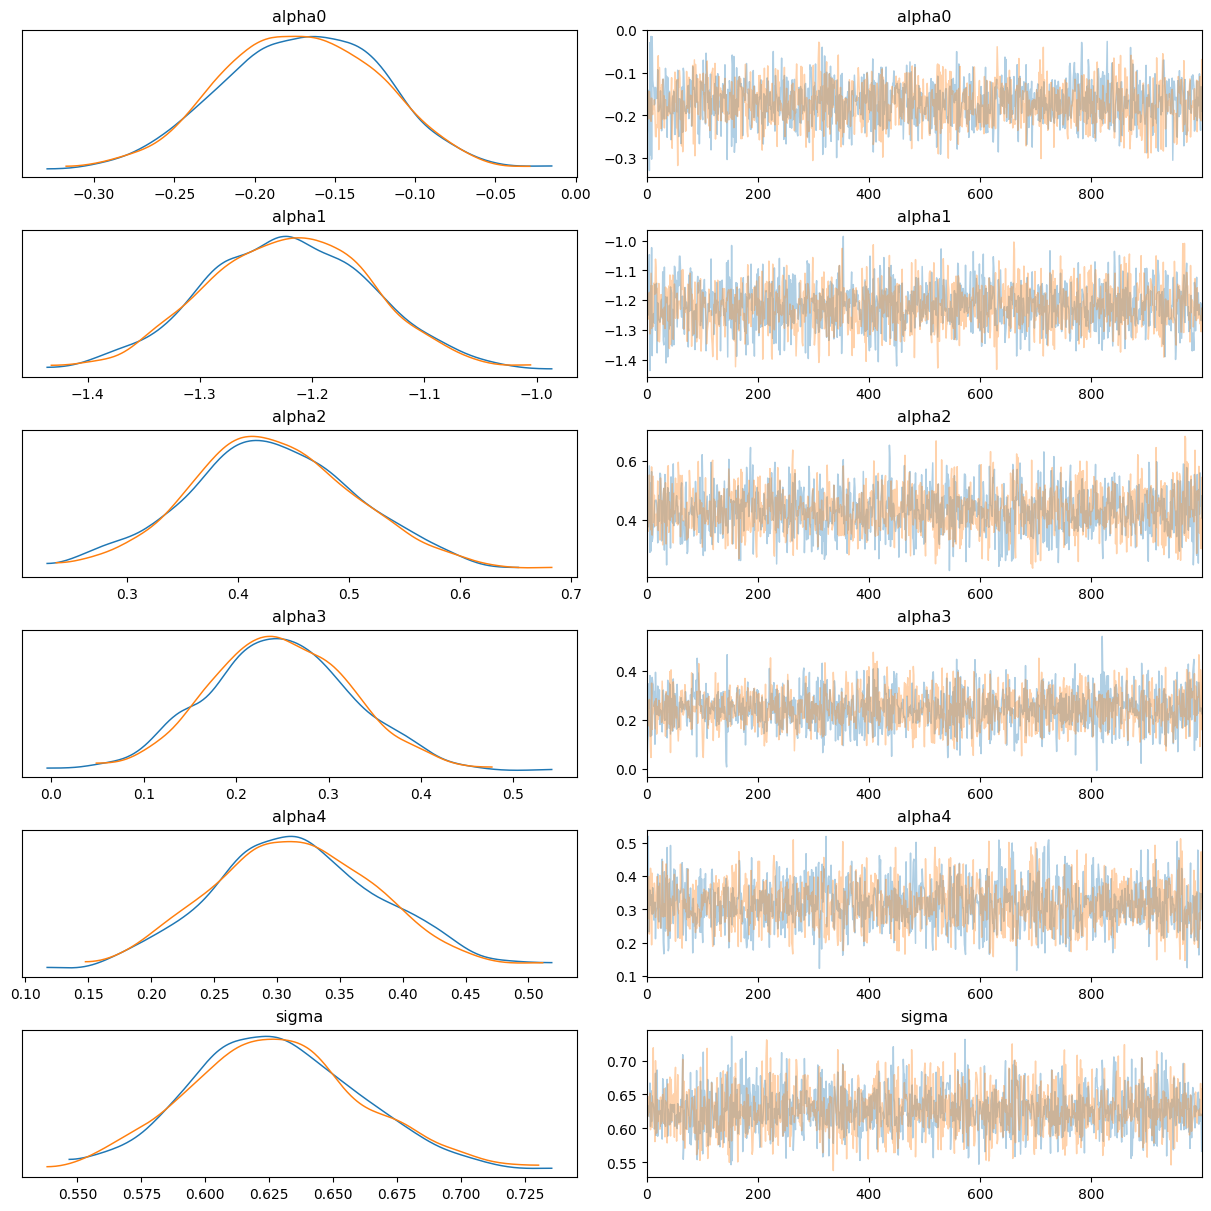

In [22]:
with model.prob_mod:
  plt.rcParams['figure.constrained_layout.use'] = True
  az.plot_trace(model.trace, compact = False)

In [23]:
ppc = model.ppc(data_c1, target, seed=1)

Sampling: [out]
INFO:pymc.sampling.forward:Sampling: [out]


In [24]:
pred_ppc = ppc.posterior_predictive["out"].mean(("chain", "draw"))

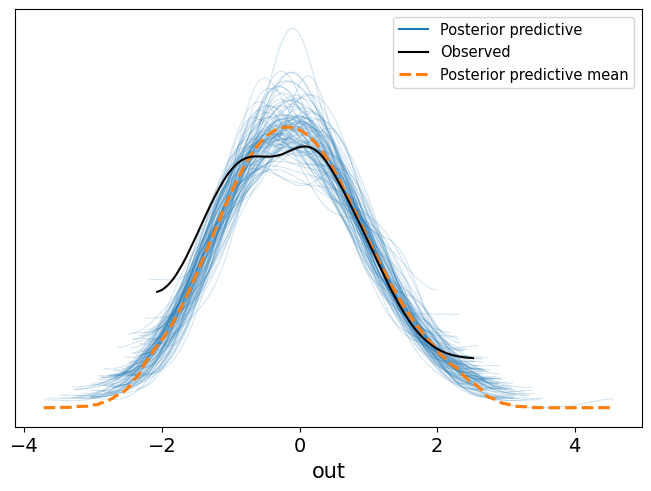

In [25]:
az.plot_ppc(ppc, num_pp_samples=100);

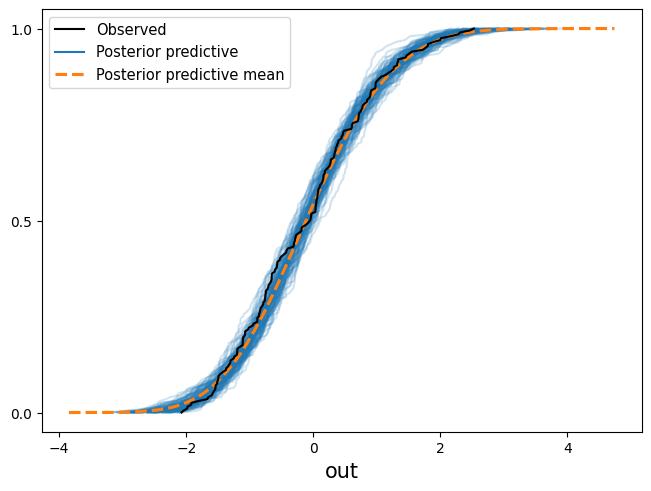

In [26]:
az.plot_ppc(ppc, kind="cumulative", num_pp_samples=100);

We can then sequentially update the posterior using the next dataset.

In [27]:
model.sample(data_c2, target, beta=1, trace = model.trace)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trace_prior_]
INFO:pymc.sampling.mcmc:NUTS: [trace_prior_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [28]:
az.summary(model.trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
trace_prior_[0]  0.151  0.542  -0.856    1.238      0.011    0.012    2611.0   
trace_prior_[1]  1.180  0.515   0.228    2.155      0.010    0.007    2731.0   
trace_prior_[2]  0.441  0.615  -0.721    1.552      0.012    0.012    2475.0   
trace_prior_[3] -0.712  0.538  -1.684    0.326      0.010    0.008    2658.0   
trace_prior_[4]  0.047  0.589  -1.135    1.125      0.012    0.013    2443.0   
trace_prior_[5]  0.272  0.543  -0.745    1.275      0.010    0.011    2681.0   
alpha0          -0.163  0.027  -0.213   -0.109      0.001    0.000    2611.0   
alpha1          -1.147  0.037  -1.214   -1.076      0.001    0.000    2730.0   
alpha2           0.468  0.047   0.381    0.556      0.001    0.001    2487.0   
alpha3           0.193  0.041   0.117    0.268      0.001    0.001    2710.0   
alpha4           0.302  0.042   0.231    0.386      0.001    0.001    2558.0   
sigma            0.637  0.018   0.606    0.673      0.000    0.000    2769.0   

                 ess_tail  r_hat  
trace_prior_[0]    1525.0    1.0  
trace_prior_[1]    1757.0    1.0  
trace_prior_[2]    1547.0    1.0  
trace_prior_[3]    1780.0    1.0  
trace_prior_[4]    1506.0    1.0  
trace_prior_[5]    1410.0    1.0  
alpha0             1525.0    1.0  
alpha1             1900.0    1.0  
alpha2             1594.0    1.0  
alpha3             1791.0    1.0  
alpha4             1504.0    1.0  
sigma              1526.0    1.0

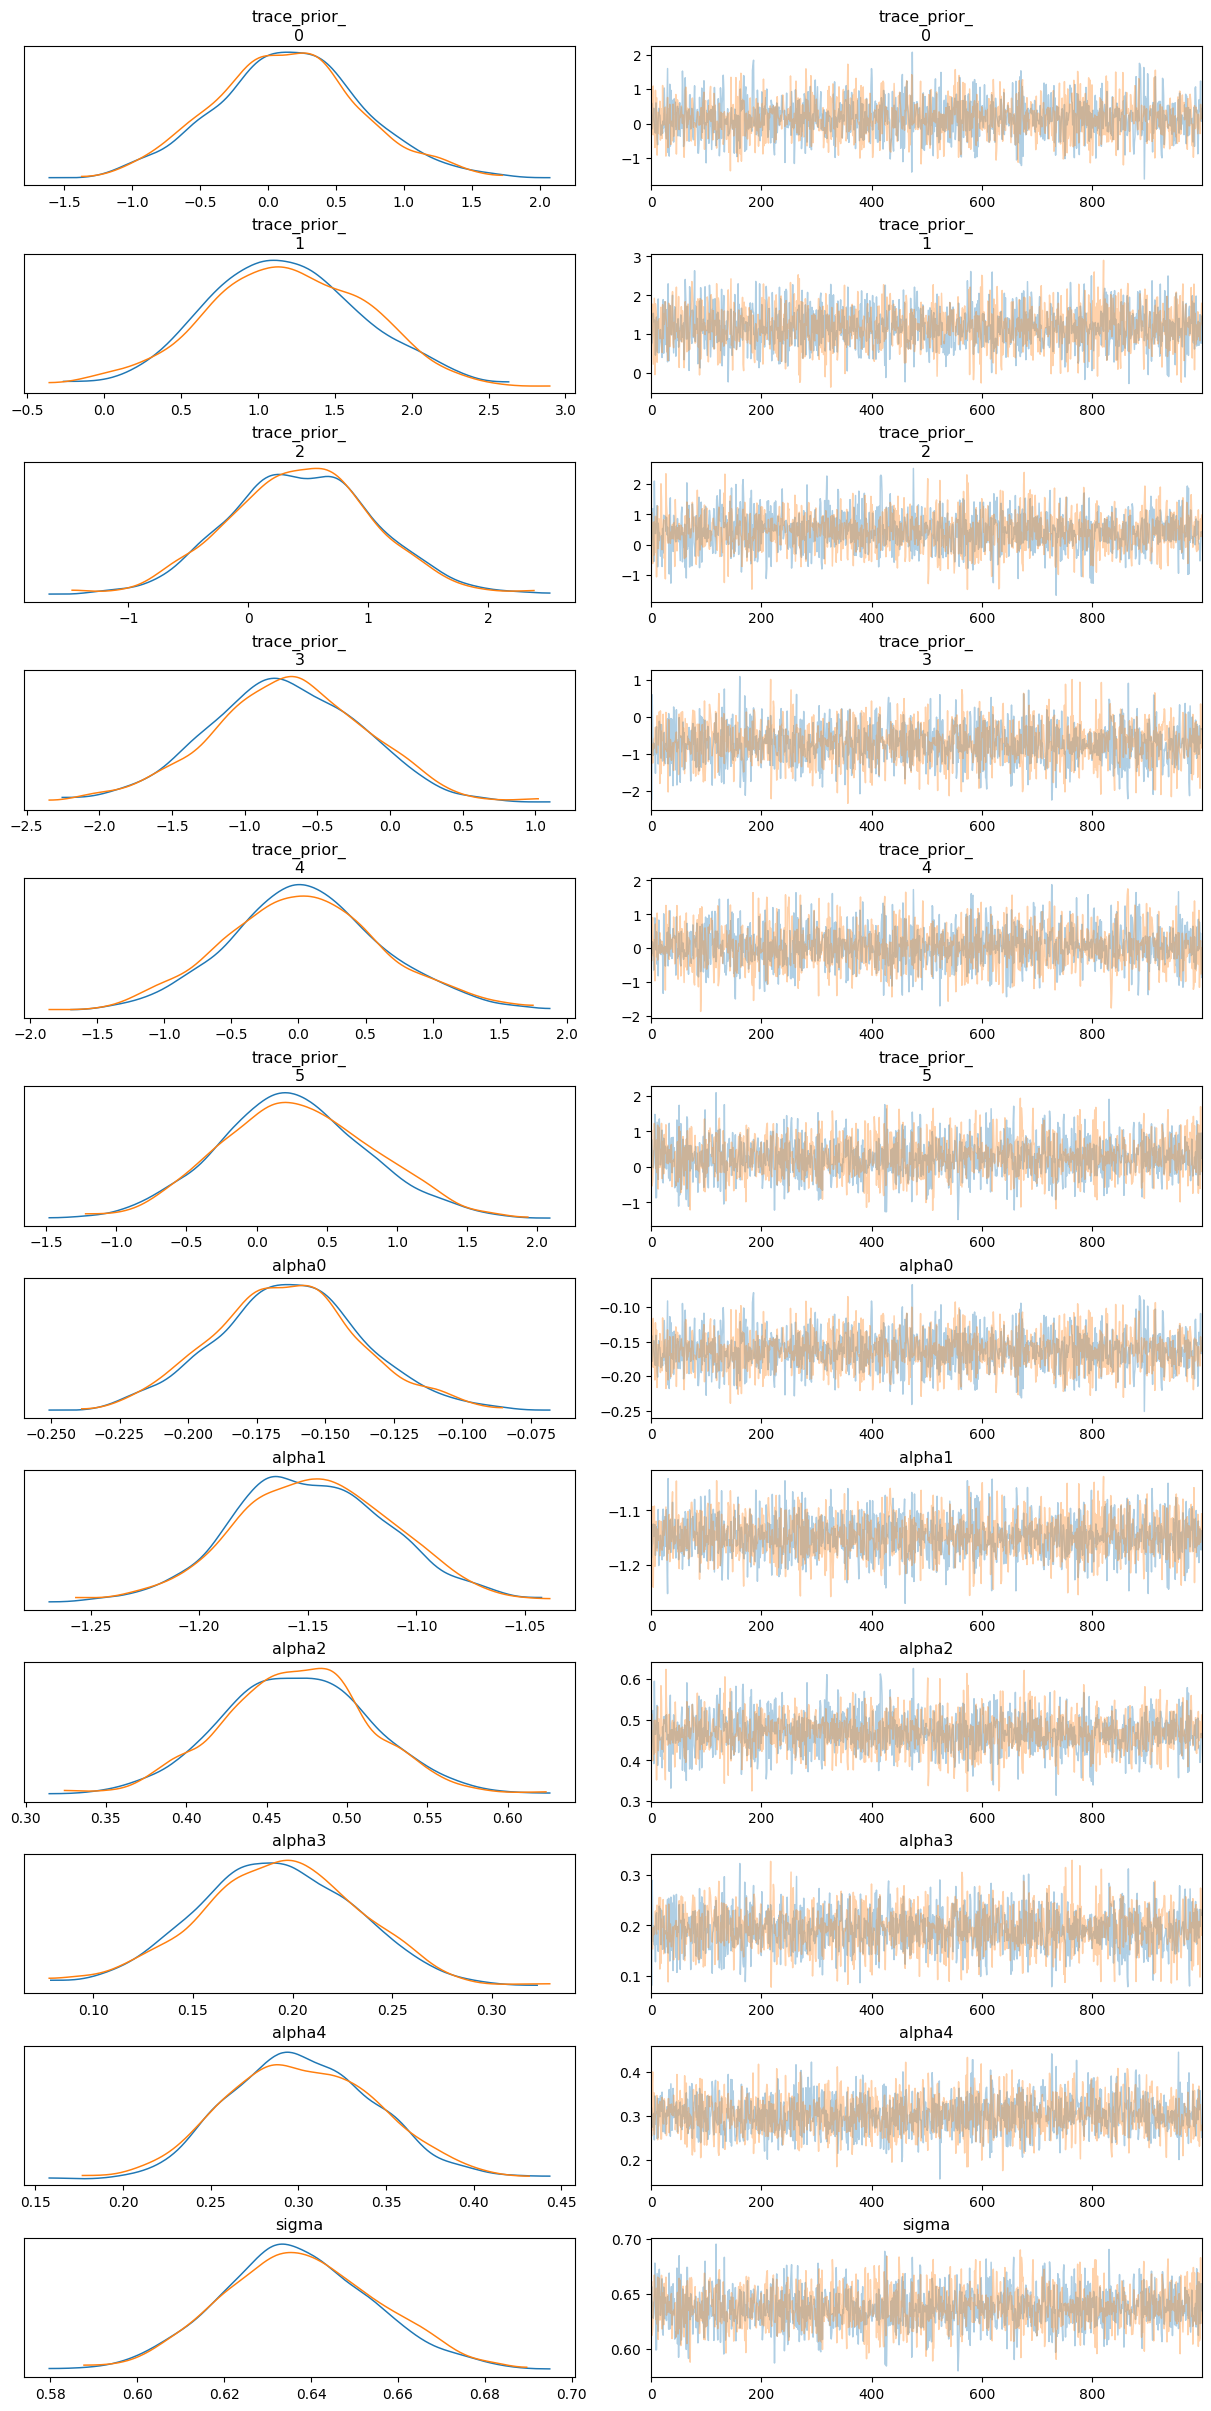

In [29]:
with model.prob_mod:
  plt.rcParams['figure.constrained_layout.use'] = True
  az.plot_trace(model.trace, compact = False)

We can check the covariance matrix of the prior distribution.

In [30]:
model.cov_prior

array([[ 2.45602661e-03, -1.53776955e-03, -6.12431236e-04,
         3.28526031e-04, -5.00709768e-04,  3.25677919e-05],
       [-1.53776955e-03,  5.39141040e-03,  7.66476924e-04,
        -1.84921622e-04,  2.60086048e-04, -3.90526650e-05],
       [-6.12431236e-04,  7.66476924e-04,  5.64836684e-03,
        -4.03533563e-04, -2.99167965e-03, -8.59619746e-05],
       [ 3.28526031e-04, -1.84921622e-04, -4.03533563e-04,
         5.78498886e-03, -4.42054864e-04, -1.01343947e-04],
       [-5.00709768e-04,  2.60086048e-04, -2.99167965e-03,
        -4.42054864e-04,  4.55531255e-03,  1.18437358e-04],
       [ 3.25677919e-05, -3.90526650e-05, -8.59619746e-05,
        -1.01343947e-04,  1.18437358e-04,  1.09848624e-03]])

In [31]:
_, _, _, n_const = model._get_lamb_expr()
var_names = [ f"alpha{i}" for i in range(n_const)]+["sigma"]
px.imshow(model.cov_prior, x=var_names, y=var_names, color_continuous_scale='RdBu_r')


In [32]:
def cor_from_cov(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation
_, _, _, n_const = model._get_lamb_expr()
var_names = [ f"alpha{i}" for i in range(n_const)]+["sigma"]
px.imshow(cor_from_cov(model.cov_prior), x=var_names, y=var_names, color_continuous_scale='RdBu_r')

In [33]:
ppc = model.ppc(data_c2, target)

Sampling: [out]
INFO:pymc.sampling.forward:Sampling: [out]


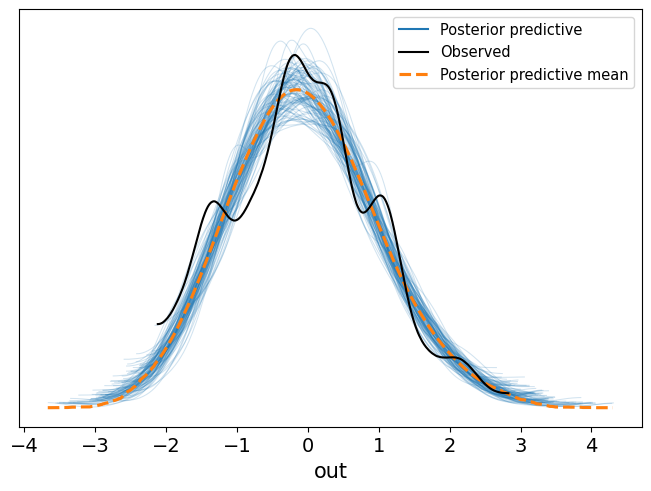

In [34]:
az.plot_ppc(ppc, num_pp_samples=100);

In [35]:
pps = model.pps(data, seed=1)

Sampling: [out]
INFO:pymc.sampling.forward:Sampling: [out]


In [36]:
pred_pps =  pps.predictions["out"].mean(("chain", "draw"))
#pred_pps

In [37]:
np.mean(np.abs(pred_pps-data[target]))

<xarray.DataArray ()> Size: 8B
array(0.48876833)

In [38]:
np.mean(np.abs(data[target]))

0.8127571212266169

In [39]:
model.compute_within(data, target)

Sampling: [out]
INFO:pymc.sampling.forward:Sampling: [out]


(0.5070028011204482, 0.9624649859943978)

Return the programs within a certain distance from the program with the highest hypervolume.

In [40]:
st = sr.get_delta_programs(3)
st

Compute the posterior sequentially using all the datasets. The posterior is normalized using a fixed number of samples n0.

In [41]:
st1 = st[0]

In [42]:
st1.compute_posterior_seq(n0=200)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha0, alpha1, alpha2, alpha3, sigma]
INFO:pymc.sampling.mcmc:NUTS: [alpha0, alpha1, alpha2, alpha3, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trace_prior_]
INFO:pymc.sampling.mcmc:NUTS: [trace_prior_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trace_prior_]
INFO:pymc.sampling.mcmc:NUTS: [trace_prior_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [43]:
az.summary(st1.trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
trace_prior_[0]  0.125  0.802  -1.401    1.595      0.019    0.017    1735.0   
trace_prior_[1] -0.067  0.903  -1.838    1.541      0.017    0.021    2702.0   
trace_prior_[2] -0.121  0.782  -1.532    1.335      0.016    0.016    2312.0   
trace_prior_[3]  0.340  0.880  -1.413    1.887      0.018    0.019    2356.0   
trace_prior_[4]  0.131  0.800  -1.359    1.680      0.017    0.017    2219.0   
alpha0           0.315  0.053   0.214    0.412      0.001    0.001    1735.0   
alpha1          -0.274  0.023  -0.319   -0.234      0.000    0.000    2680.0   
alpha2           0.534  0.034   0.469    0.597      0.001    0.001    2071.0   
alpha3          -0.338  0.011  -0.359   -0.316      0.000    0.000    2377.0   
sigma            0.636  0.018   0.603    0.670      0.000    0.000    2191.0   

                 ess_tail  r_hat  
trace_prior_[0]    1333.0    1.0  
trace_prior_[1]    1410.0    1.0  
trace_prior_[2]    1599.0    1.0  
trace_prior_[3]    1512.0    1.0  
trace_prior_[4]    1313.0    1.0  
alpha0             1333.0    1.0  
alpha1             1455.0    1.0  
alpha2             1580.0    1.0  
alpha3             1558.0    1.0  
sigma              1228.0    1.0

If we use the Sequential Monte Carlo sampler we obtain also the marginal likelihood (or evidence), which can be used to compute the Bayes factor.

In [44]:
model.compute_posterior_seq(n0=200, method="SMC")

Initializing SMC sampler...
INFO:pymc.smc.sampling:Initializing SMC sampler...
Sampling 2 chains in 1 job
INFO:pymc.smc.sampling:Sampling 2 chains in 1 job


We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing SMC sampler...
INFO:pymc.smc.sampling:Initializing SMC sampler...
Sampling 2 chains in 1 job
INFO:pymc.smc.sampling:Sampling 2 chains in 1 job


We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing SMC sampler...
INFO:pymc.smc.sampling:Initializing SMC sampler...
Sampling 2 chains in 1 job
INFO:pymc.smc.sampling:Sampling 2 chains in 1 job


We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [45]:
model.trace.sample_stats["log_marginal_likelihood"]

<xarray.DataArray 'log_marginal_likelihood' (chain: 2, draw: 1)> Size: 16B
array([[-190.9506846094274],
       [-190.96354392581296]], dtype=object)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 8B 0

All the log marginal likelihoods are stored so that they then be summed up to obtain the whole log marginal likelihood.

In [46]:
model.marginal_likelihood

[-192.52971315626965, -195.70564207458628, -190.95711426762017]

In [47]:
sum(model.marginal_likelihood)

-579.1924694984762

The following method returns the prior probability of the model generated by the genetic algorithm.

In [48]:
np.log(model.program._get_probability(0.9, 0.95))

-18.554758559572907

In [49]:
len(features)

9

In [50]:
model = sr.generate_individual(data_c1, features, operations, fitness_functions)
model.program

cos((is_male * (1.9999497097571057 / age)))

In [51]:
np.log(model.program._get_probability(0.9, 0.95))

-5.09624741911292

In [52]:
model.program._get_probability(0.9, 0.95)*100

0.6119668080672469